In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
# load registration data
path_to_vius = 'RawData/US_VIUS_2021'
path_to_moves = 'RawData/MOVES'
path_to_experian = 'PrivateData/registration/experian' # access for private data

age_bin = [-1, 3, 5, 7, 9, 14, 19, 50]

age_bin_label = ['age<=3', '3<age<=5','5<age<=7', 
                 '7<age<=9', '9<age<=14', 
                 '14<age<=19', 'age>=20']

selected_state = 'CA'
data_filtered = True
if data_filtered:
    experian_file = 'filtered_experian_data.csv'
else:
    experian_file = 'cleanedExperian_7_Jun_24.csv'
experian_data = read_csv(os.path.join(path_to_experian,
                                     experian_file))
experian_data.loc[:, 'assign_wt_class'] = \
experian_data.loc[:, 'assign_wt_class'].astype(str)
print(len(experian_data))
experian_data.head(5)

545994


,Unnamed: 0,state_abbr,county_name,fuel_ty,model_year,naics_lvl3,age,assign_wt_class,body_merged,vehicle_count,body_type,AGE_BIN
0,1,CA,ALAMEDA,Biodiesel,2011,221,12,2B,Pickup,1.0,Pickup,9<age<=14
1,2,CA,ALAMEDA,Biodiesel,2011,237,12,2B,Pickup,7.0,Pickup,9<age<=14
2,6,CA,ALAMEDA,Biodiesel,2011,519,12,2A,Pickup,2.0,Pickup,9<age<=14
3,9,CA,ALAMEDA,Biodiesel,2011,541,12,2A,Pickup,2.0,Pickup,9<age<=14
4,16,CA,ALAMEDA,Biodiesel,2012,238,11,2A,Pickup,5.0,Pickup,9<age<=14


In [3]:
print(experian_data.assign_wt_class.unique())

[2 3 5 8 6 7 4]


# Part 1 - filter experian data
## Assign class 2a/2b
## Select commercial vehicles

In [4]:
# load additional parameters
# assign 2a/2b to class 2
vius_2a2b_split = read_csv(os.path.join(path_to_vius, 'parameter',
                                        'class_2a2b_by_body_type.csv'))
vius_2a2b_split = \
vius_2a2b_split.groupby(['BTYPE', 'GVWR_CLASS'])[['TABWEIGHT']].sum()
vius_2a2b_split = vius_2a2b_split.reset_index()
vius_2a2b_split.loc[:, 'Fraction'] = vius_2a2b_split.loc[:, 'TABWEIGHT']/ \
vius_2a2b_split.groupby('BTYPE')['TABWEIGHT'].transform('sum')
print(vius_2a2b_split.groupby('GVWR_CLASS')['TABWEIGHT'].sum())
print(vius_2a2b_split.BTYPE.unique())
vius_2a2b_split.head(5)

GVWR_CLASS
2A    62263012.3
2B    11736678.0
Name: TABWEIGHT, dtype: float64
['Chassis Cab' 'Cutaway' 'Dump' 'Pickup' 'SUV' 'Step Van' 'Van']


,BTYPE,GVWR_CLASS,TABWEIGHT,Fraction
0,Chassis Cab,2B,1.0,1.000000
1,Cutaway,2A,9659.6,0.056927
2,Cutaway,2B,160024.1,0.943073
3,Dump,2A,80.8,0.002964
4,Dump,2B,27175.1,0.997036


In [5]:
# load fraction of commercial vehicles
vius_commercial_fraction = read_csv(os.path.join(path_to_vius, 'parameter',
                                        'commercial_use_by_class.csv'))

# vius_commercial_fraction.loc[:, 'com_fraction'] = \
# vius_commercial_fraction.loc[:, 'TABWEIGHT'] / \
# vius_commercial_fraction.groupby(['GVWR_CLASS'])['TABWEIGHT'].transform('sum')
vius_commercial_fraction = \
vius_commercial_fraction.loc[vius_commercial_fraction['BUSRELATED'] == 'Some commercial activity']

vius_commercial_fraction = vius_commercial_fraction[['GVWR_CLASS', 'AGE_BIN', 
                                                     'com_fraction']]
vius_commercial_fraction.head(5)

,GVWR_CLASS,AGE_BIN,com_fraction
1,1,age<=3,0.121868
3,1,3<age<=5,0.135874
5,1,5<age<=7,0.083621
7,1,7<age<=9,0.088892
9,1,9<age<=14,0.097208


In [6]:
# clean data and drop OOS vehicle types

'''
following fleets are
40 excluded from the VIUS scope: ambulances, buses, motor homes, farm tractors, 
unpowered trailer units,
41 vehicles disposed of before January 1, 2021
'''
body_type_to_drop = ['Bus - Non-School',
                     'Bus - School', 
                     'Fire Truck', 'Motor Home', 
                     'Military', 'Unknown']
# those are dropped as they are not collected in VIUS
print(experian_data['body_merged'].unique())
experian_data = \
experian_data.loc[~experian_data['body_merged'].isin(body_type_to_drop)]

['Pickup' 'Chassis Cab' 'Cargo Van' 'Passenger Van' 'Cutaway'
 'Straight Truck' 'Tractor' 'Bus - Non-School' 'SUV' 'Bus - School'
 'Step Van' 'Fire Truck' 'Dump' 'Motor Home' 'Unknown' 'Glider' 'Van'
 'Box Van' 'Concrete' 'Military']


In [7]:
# List of body type under class 2
van_types = [ 'Cargo Van', 'Passenger Van', 'Van', 'Box Van']
experian_data.loc[:,'body_type'] = experian_data.loc[:,'body_merged']
experian_data.loc[experian_data['body_type'].isin(van_types), 'body_type'] = 'Van'
experian_data_class2 = experian_data.loc[experian_data['assign_wt_class'] == 2]
experian_data_class3above = experian_data.loc[experian_data['assign_wt_class'] > 2]

class2_body_type_to_drop = ['Concrete', 'Straight Truck', 'Tractor']
experian_data_class2 = \
experian_data_class2.loc[~experian_data_class2['body_type'].isin(class2_body_type_to_drop)]
print(experian_data_class2['body_type'].unique())
print(experian_data_class2.groupby('body_type')['vehicle_count'].sum())


['Pickup' 'Chassis Cab' 'Van' 'Cutaway' 'SUV' 'Step Van']
body_type
Chassis Cab      102882.0
Cutaway           53840.0
Pickup         10121875.0
SUV             6454655.0
Step Van           7516.0
Van             1589911.0
Name: vehicle_count, dtype: float64


In [8]:
# assign 2a and 2b to each row
experian_data_class2_assigned = None
body_types = experian_data_class2.body_type.unique()
for bt in body_types:
    # print(bt)
    experian_data_selected = \
    experian_data_class2.loc[experian_data_class2['body_type'] == bt].reset_index()
    fraction_select = \
    vius_2a2b_split.loc[vius_2a2b_split['BTYPE'] == bt]
    options = fraction_select.GVWR_CLASS.to_numpy()
    probability = fraction_select.Fraction.to_numpy()
    # assign 2a 2b
    sample_size = len(experian_data_selected)
    experian_data_selected.loc[:, 'class2'] = \
    pd.Series(np.random.choice(options, size = sample_size, p = probability) )
    experian_data_class2_assigned = pd.concat([experian_data_class2_assigned,
                                               experian_data_selected])
    # break
print(experian_data_class2_assigned.groupby('class2')[['vehicle_count']].sum())
sum_2a = \
experian_data_class2_assigned.loc[experian_data_class2_assigned['class2'] == '2A', 'vehicle_count'].sum()
sum_2b = \
experian_data_class2_assigned.loc[experian_data_class2_assigned['class2'] == '2B', 'vehicle_count'].sum()
print(sum_2a / sum_2b)
experian_data_class2_assigned.drop(columns = ['index'], inplace = True)
experian_data_class2_assigned.head(5)

        vehicle_count
class2               
2A         15699229.0
2B          2631450.0
5.9659993539683445


,state_abbr,county_name,fuel_ty,model_year,naics_lvl3,age,assign_wt_class,body_merged,vehicle_count,body_type,class2
0,CA,ALAMEDA,Biodiesel,2011,,12,2,Pickup,1.0,Pickup,2A
1,CA,ALAMEDA,Biodiesel,2011,221,12,2,Pickup,1.0,Pickup,2B
2,CA,ALAMEDA,Biodiesel,2011,237,12,2,Pickup,7.0,Pickup,2B
3,CA,ALAMEDA,Biodiesel,2011,238,12,2,Pickup,1.0,Pickup,2A
4,CA,ALAMEDA,Biodiesel,2011,326,12,2,Pickup,1.0,Pickup,2B


In [9]:
# merge processed data
experian_data_class2_assigned.loc[:, 'assign_wt_class']= \
experian_data_class2_assigned.loc[:, 'class2']

experian_data_class2_assigned.drop(columns = ['class2'], inplace = True)
experian_data_processed = pd.concat([experian_data_class2_assigned,
                                    experian_data_class3above])
experian_data_processed.head(5)

,state_abbr,county_name,fuel_ty,model_year,naics_lvl3,age,assign_wt_class,body_merged,vehicle_count,body_type
0,CA,ALAMEDA,Biodiesel,2011,,12,2A,Pickup,1.0,Pickup
1,CA,ALAMEDA,Biodiesel,2011,221,12,2B,Pickup,1.0,Pickup
2,CA,ALAMEDA,Biodiesel,2011,237,12,2B,Pickup,7.0,Pickup
3,CA,ALAMEDA,Biodiesel,2011,238,12,2A,Pickup,1.0,Pickup
4,CA,ALAMEDA,Biodiesel,2011,326,12,2B,Pickup,1.0,Pickup


In [10]:
# Select fleet for business



experian_data_processed.loc[:, 'AGE_BIN'] = \
pd.cut(experian_data_processed.loc[:, 'age'],
       bins = age_bin,
       labels = age_bin_label)
print(len(experian_data_processed))
experian_data_processed['assign_wt_class'] = experian_data_processed['assign_wt_class'].astype(str)

experian_data_com_sample = pd.merge(experian_data_processed,
                                   vius_commercial_fraction,
                                   left_on = ['assign_wt_class', 'AGE_BIN'],
                                   right_on = ['GVWR_CLASS', 'AGE_BIN'],
                                   how = 'left')
experian_data_com_sample.drop(columns = ['GVWR_CLASS'], inplace = True)

experian_data_com_sample['randnum'] = np.random.rand(len(experian_data_com_sample))
experian_data_com_sample.loc[:, 'com_use'] = 0
com_idx = (experian_data_com_sample['randnum'] <= experian_data_com_sample['com_fraction'])
experian_data_com_sample.loc[com_idx, 'com_use'] = 1

print(len(experian_data_com_sample))
print(experian_data_com_sample.groupby('com_use')[['vehicle_count']].sum())
experian_data_com_sample.head(5)

1151822
1151822
         vehicle_count
com_use               
0           15637338.0
1            5534255.0


,state_abbr,county_name,fuel_ty,model_year,naics_lvl3,age,assign_wt_class,body_merged,vehicle_count,body_type,AGE_BIN,com_fraction,randnum,com_use
0,CA,ALAMEDA,Biodiesel,2011,,12,2A,Pickup,1.0,Pickup,9<age<=14,0.147508,0.924379,0
1,CA,ALAMEDA,Biodiesel,2011,221,12,2B,Pickup,1.0,Pickup,9<age<=14,0.517386,0.037338,1
2,CA,ALAMEDA,Biodiesel,2011,237,12,2B,Pickup,7.0,Pickup,9<age<=14,0.517386,0.265396,1
3,CA,ALAMEDA,Biodiesel,2011,238,12,2A,Pickup,1.0,Pickup,9<age<=14,0.147508,0.686490,0
4,CA,ALAMEDA,Biodiesel,2011,326,12,2B,Pickup,1.0,Pickup,9<age<=14,0.517386,0.810897,0


In [11]:
# check realized commercial vehicles
com_veh_by_class = \
experian_data_com_sample.groupby(['assign_wt_class', 'com_use'])[['vehicle_count']].sum()

com_veh_by_class = com_veh_by_class.reset_index()
com_veh_by_class.loc[:, 'com_fraction'] = \
com_veh_by_class.loc[:, 'vehicle_count'] / \
com_veh_by_class.groupby('assign_wt_class')['vehicle_count'].transform('sum')

com_veh_by_class = com_veh_by_class.loc[com_veh_by_class['com_use'] == 1]
com_veh_by_class

,assign_wt_class,com_use,vehicle_count,com_fraction
1,2A,1,2392923.0,0.152423
3,2B,1,1213787.0,0.461262
5,3,1,534137.0,0.464007
7,4,1,180461.0,0.690633
9,5,1,185026.0,0.889403
11,6,1,185148.0,0.810606
13,7,1,123721.0,0.790216
15,8,1,719052.0,0.860658


In [13]:
# keep commercial samples
experian_data_com_sample = \
experian_data_com_sample.loc[experian_data_com_sample['com_use'] == 1]
experian_data_com_sample.drop(columns = ['com_fraction', 'randnum', 'com_use'],
                             inplace = True)
experian_data_com_sample.to_csv(os.path.join(path_to_experian,
                                     'filtered_experian_data.csv'))

In [12]:
print(experian_data_com_sample.assign_wt_class.unique())

['2A' '2B' '3' '5' '8' '6' '7' '4']


# Part 2 - process state-level data
## generate state-level statistics and plots

total trucks in CA registration data:
2281207.0
trucks by GWVR class in CA registration data:
                 vehicle_count
assign_wt_class               
2A                    982082.0
2B                    442600.0
3                     171023.0
4                      94170.0
5                      95032.0
6                     104873.0
7                      67095.0
8                     324332.0


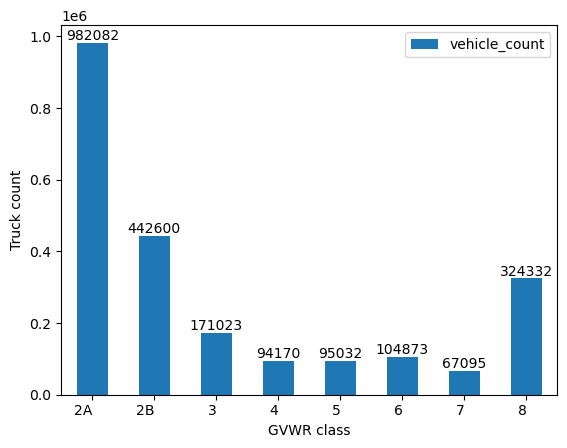

In [3]:
# select state-level results

# body_type_to_drop = ['Passenger Van', 'Bus - Non-School',
#        'Bus - School', 'Fire Truck', 'Motor Home', 'Military', 'Unknown']
# print(experian_data['body_merged'].unique())

if data_filtered:
    experian_data = experian_data
else:
    experian_data = experian_data_com_sample
experian_data_state = \
experian_data.loc[experian_data['state_abbr'] == selected_state]

# experian_data_state = \
# experian_data_state.loc[~experian_data_state['body_merged'].isin(body_type_to_drop)]

drop_class_2 = 0
if drop_class_2 == 1:
    experian_data_state = \
    experian_data_state.loc[~experian_data_state['assign_wt_class'].isin(['2A', '2B'])]
print('total trucks in {} registration data:'.format(selected_state))
print(experian_data_state.vehicle_count.sum())

experian_data_by_class = \
experian_data_state.groupby(['assign_wt_class'])[['vehicle_count']].sum()
print('trucks by GWVR class in {} registration data:'.format(selected_state))
print(experian_data_by_class)

experian_data_by_class.to_csv(os.path.join(path_to_experian, 'experian_count_' + selected_state + '.csv'))
ax = experian_data_by_class.plot(kind = 'bar')
rects = ax.patches

# Make some labels.
experian_data_by_class['vehicle_count'] = \
experian_data_by_class['vehicle_count'].astype(int)
labels = experian_data_by_class['vehicle_count'].tolist()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.xlabel('GVWR class')
plt.ylabel('Truck count')
plt.xticks(rotation = 0, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', selected_state + '_count_by_class.png'),
           bbox_inches = 'tight')
plt.show()

In [4]:
# assign SynthFirm types
# body type assignment
class_label_mapping = {'Pickup': 'Vocational', 
                       'Chassis Cab': 'Vocational', 
                       'Cargo Van': 'Vocational', 
                       'Passenger Van': 'Vocational',
                       'Cutaway': 'Vocational', 
                       'Straight Truck': 'Vocational',
                       'Tractor': 'Tractor', 
                       'SUV': 'Vocational', 
                       'Step Van': 'Vocational', 
                       'Dump': 'Vocational', 
                       'Glider':'Tractor', 
                       'Van': 'Vocational',     
                       'Box Van':'Vocational', 
                       'Concrete': 'Vocational'}

ldt1_classes = ['2A']
ldt2_classes = ['2B', '3']
md_classes = ['4', '5', '6']
hd_classes = ['7', '8']
# print(experian_data['assign_wt_class'].unique())
experian_data_state.loc[:, 'body_type'] = \
experian_data_state.loc[:, 'body_merged'].map(class_label_mapping)
experian_data_state.loc[:, 'veh_class'] = 'Light-duty Class12A'

ldt2_criteria = (experian_data_state['assign_wt_class'].isin(ldt2_classes))
experian_data_state.loc[ldt2_criteria, 'veh_class'] = 'Light-duty Class2B3'

md_criteria = (experian_data_state['assign_wt_class'].isin(md_classes))
experian_data_state.loc[md_criteria, 'veh_class'] = 'Medium-duty Vocational'

hd_voc_criteria = (experian_data_state['assign_wt_class'].isin(hd_classes) & \
                   (experian_data_state['body_type'] == 'Vocational'))
experian_data_state.loc[hd_voc_criteria,'veh_class'] = 'Heavy-duty Vocational'

hd_trc_criteria = (experian_data_state['assign_wt_class'].isin(hd_classes) & \
                   (experian_data_state['body_type'] == 'Tractor'))
experian_data_state.loc[hd_trc_criteria,'veh_class'] = 'Heavy-duty Tractor'
print(experian_data_state.veh_class.unique())

['Light-duty Class2B3' 'Light-duty Class12A' 'Medium-duty Vocational'
 'Heavy-duty Vocational' 'Heavy-duty Tractor']


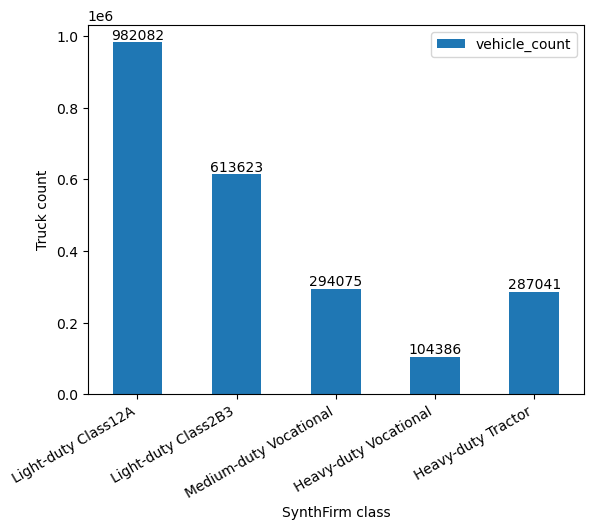

In [5]:
# plot by synthfirm class
order_of_row = ['Light-duty Class12A',
                'Light-duty Class2B3',
                'Medium-duty Vocational',
                'Heavy-duty Vocational', 
                'Heavy-duty Tractor']
experian_data_by_class = \
experian_data_state.groupby(['veh_class'])[['vehicle_count']].sum()
experian_data_by_class = experian_data_by_class.loc[order_of_row]
# experian_data_by_class.to_csv(os.path.join(path_to_experian, 'experian_count_' + selected_state + '.csv'))
ax = experian_data_by_class.plot(kind = 'bar')
rects = ax.patches

# Make some labels.
experian_data_by_class['vehicle_count'] = \
experian_data_by_class['vehicle_count'].astype(int)
labels = experian_data_by_class['vehicle_count'].tolist()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.xlabel('SynthFirm class')
plt.ylabel('Truck count')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', selected_state + '_count_by_synthfirm_class.png'),
           bbox_inches = 'tight')
plt.show()

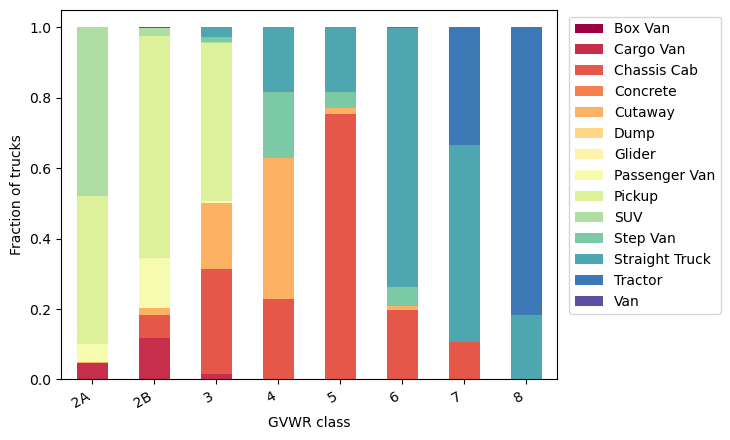

In [12]:
# look into gvwr class and body type crosstab
class_and_body_type = pd.pivot_table(experian_data_state,
                                     index = 'assign_wt_class',
                                     columns = 'body_merged',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
# normalize
class_and_body_type.to_csv(os.path.join(path_to_experian, \
                                        selected_state + '_truck_count_by_body_type_and_class.csv'))
class_label = experian_data_state.body_merged.unique()
class_and_body_type.loc[:, class_label] = \
    class_and_body_type.loc[:, class_label].div(class_and_body_type.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_type.plot(kind = 'bar', stacked = True, cmap= 'Spectral')
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()



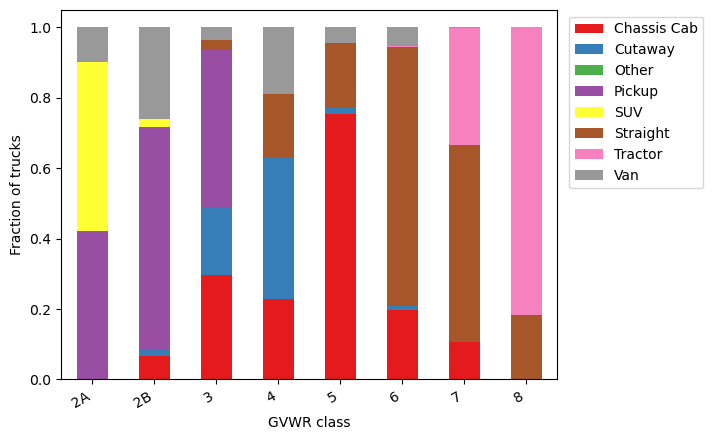

In [13]:
# body type combination
body_type_agg_label_mapping = {'Pickup': 'Pickup', 
                       'Chassis Cab': 'Chassis Cab', 
                       'Cargo Van': 'Van', 
                       'Passenger Van': 'Van',
                       'Cutaway': 'Cutaway', 
                       'Straight Truck': 'Straight',
                       'Tractor': 'Tractor', 
                       'SUV': 'SUV', 
                       'Step Van': 'Van', 
                       'Dump': 'Other', 
                       'Glider':'Other', 
                       'Van': 'Van',     
                       'Box Van':'Van', 
                       'Concrete': 'Other'}

experian_data_state.loc[:, 'body_type_agg'] = \
experian_data_state.loc[:, 'body_merged'].map(body_type_agg_label_mapping)

class_and_body_agg_group = pd.pivot_table(experian_data_state,
                                     index = 'assign_wt_class',
                                     columns = 'body_type_agg',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
# normalize
class_label = experian_data_state.body_type_agg.unique()
class_and_body_agg_group.loc[:, class_label] = \
    class_and_body_agg_group.loc[:, class_label].div(class_and_body_agg_group.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_agg_group.plot(kind = 'bar', stacked = True, cmap= 'Set1')
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_body_class.png'), bbox_inches = 'tight')
plt.show()

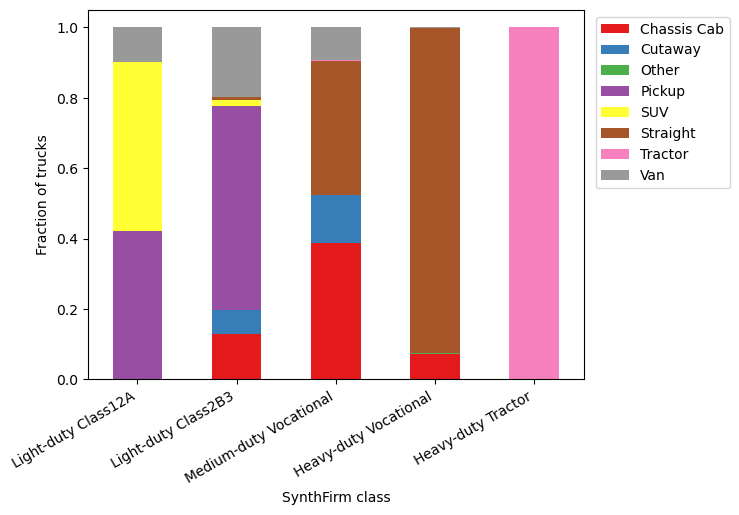

In [15]:
class_and_body_agg_group = pd.pivot_table(experian_data_state,
                                     index = 'veh_class',
                                     columns = 'body_type_agg',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
class_and_body_agg_group = class_and_body_agg_group.loc[order_of_row]
# normalize
class_label = experian_data_state.body_type_agg.unique()
class_and_body_agg_group.loc[:, class_label] = \
    class_and_body_agg_group.loc[:, class_label].div(class_and_body_agg_group.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_agg_group.plot(kind = 'bar', stacked = True, cmap= 'Set1')
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('SynthFirm class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_body_synthfirm_class.png'), bbox_inches = 'tight')
plt.show()

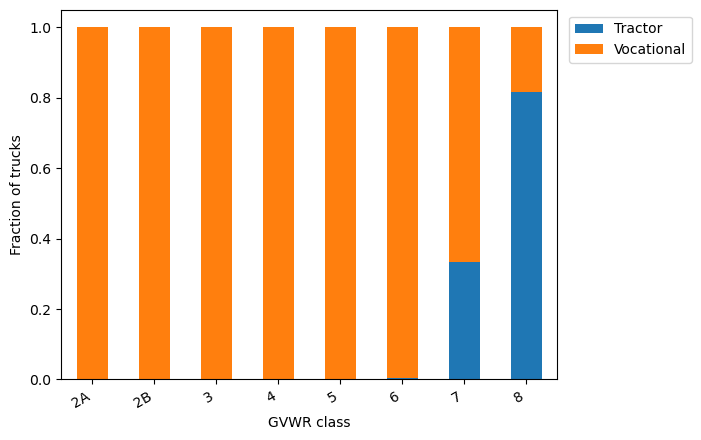

In [16]:
class_and_body_group = pd.pivot_table(experian_data_state,
                                     index = 'assign_wt_class',
                                     columns = 'body_type',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
# normalize
class_label = experian_data_state.body_type.unique()
class_and_body_group.loc[:, class_label] = \
    class_and_body_group.loc[:, class_label].div(class_and_body_group.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_group.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_tractor_class.png'), bbox_inches = 'tight')
plt.show()

0
42
1981
2023


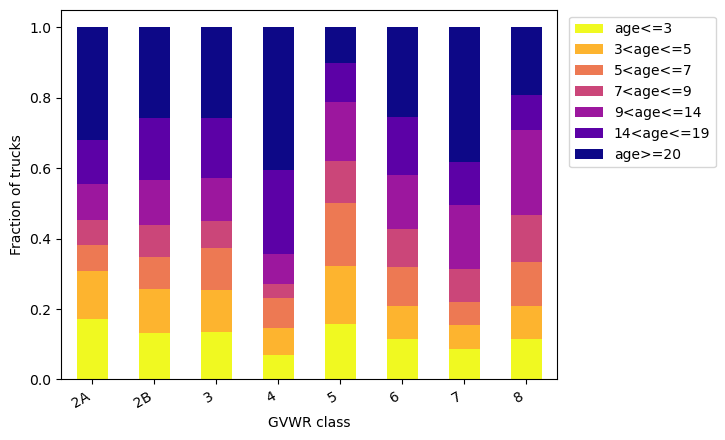

In [17]:
# AGE DISTRIBUTION
print(experian_data.age.min())
print(experian_data.age.max())

print(experian_data.model_year.min())
print(experian_data.model_year.max())



def weighted_median_by_count(df):
    df_sorted = df.sort_values('age')
    cumsum = df_sorted['vehicle_count'].cumsum()
    cutoff = df_sorted['vehicle_count'].sum() / 2.
    median = df_sorted[cumsum >= cutoff]['age'].iloc[0]
    return(median)
median_age_experian = \
experian_data_state.groupby(['state_abbr', 'assign_wt_class']).apply(weighted_median_by_count)    
median_age_experian.to_csv(os.path.join(path_to_experian, 
                                        selected_state + '_median_age_by_state.csv'))

# experian_data.loc[:, 'age_bin'] = pd.cut(experian_data.loc[:, 'age'], 
#                                         bins = age_bin,
#                                         labels = age_bin_label)

class_and_age_bin = pd.pivot_table(experian_data_state,
                                   index = 'assign_wt_class',
                                   columns = 'AGE_BIN',
                                   values = 'vehicle_count',
                                   aggfunc = 'sum')
# normalize
# class_label = experian_data.body_merged.unique()
class_and_age_bin.loc[:, age_bin_label] = \
    class_and_age_bin.loc[:, age_bin_label].div(class_and_age_bin.loc[:, age_bin_label].sum(axis=1), axis=0)
# plot
class_and_age_bin = class_and_age_bin.loc[:, age_bin_label]
class_and_age_bin.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'plasma_r')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_age_class.png'), bbox_inches = 'tight')
plt.show()



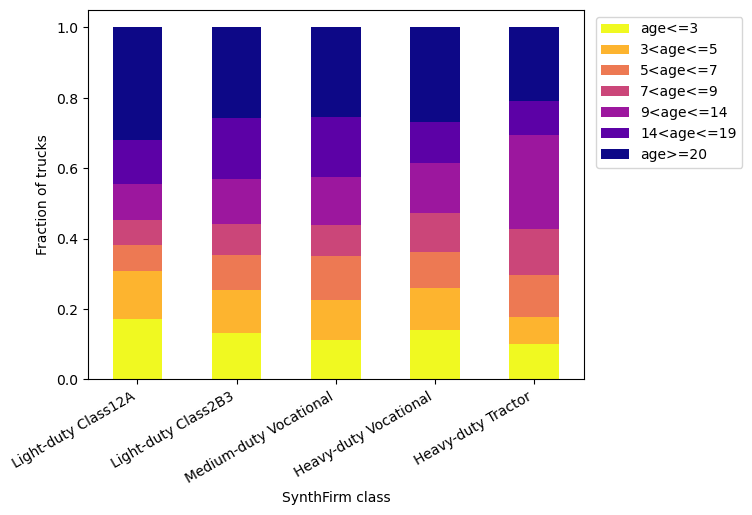

In [18]:
class_and_age_bin = pd.pivot_table(experian_data_state,
                                   index = 'veh_class',
                                   columns = 'AGE_BIN',
                                   values = 'vehicle_count',
                                   aggfunc = 'sum')
class_and_age_bin = class_and_age_bin.loc[order_of_row]
# normalize
# class_label = experian_data.body_merged.unique()
class_and_age_bin.loc[:, age_bin_label] = \
    class_and_age_bin.loc[:, age_bin_label].div(class_and_age_bin.loc[:, age_bin_label].sum(axis=1), axis=0)
# plot
class_and_age_bin = class_and_age_bin.loc[:, age_bin_label]
class_and_age_bin.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'plasma_r')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('SynthFirm class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_age_synthfirm_class.png'), 
            bbox_inches = 'tight')
plt.show()

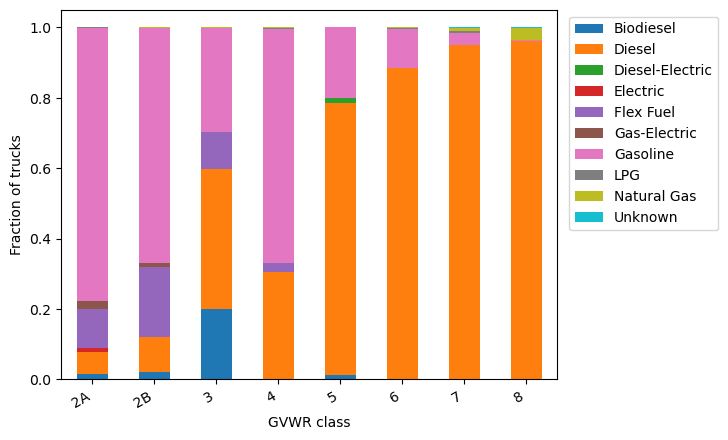

In [19]:
# FUEL TYPE DISTRIBUTION
experian_data.fuel_ty.unique()
fuel_type_mapping = {'Biodiesel':'Diesel', 
                     'Diesel-Electric': 'Hybrid', 
                     'Diesel':'Diesel', 
                     'Electric': 'Electric', 
                     'Flex Fuel': 'Other',
                     'Gas-Electric': 'Hybrid', 
                     'Gasoline': 'Gasoline', 
                     'LPG': 'Other', 
                     'Natural Gas': 'CNG', 
                     'Unknown': 'Other'}

# NO MAPPING

class_and_fuel = pd.pivot_table(experian_data_state,
                                index = 'assign_wt_class',
                                columns = 'fuel_ty',
                                values = 'vehicle_count',
                                aggfunc = 'sum')
# normalize
class_label = experian_data_state.fuel_ty.unique()
class_and_fuel.loc[:, class_label] = \
    class_and_fuel.loc[:, class_label].div(class_and_fuel.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_fuel.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'tab10')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()



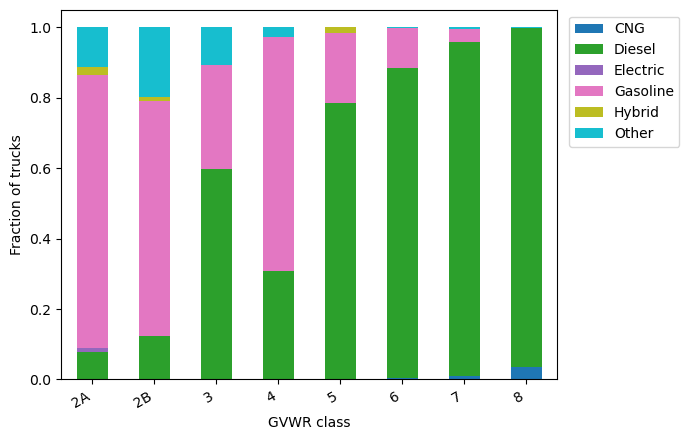

In [20]:
# with MAPPING
experian_data_state.loc[:, 'fuel_type_1'] =\
experian_data_state.loc[:, 'fuel_ty'].map(fuel_type_mapping)
class_and_fuel = pd.pivot_table(experian_data_state,
                                index = 'assign_wt_class',
                                columns = 'fuel_type_1',
                                values = 'vehicle_count',
                                aggfunc = 'sum')
# normalize
class_label = experian_data_state.fuel_type_1.unique()
class_and_fuel.loc[:, class_label] = \
    class_and_fuel.loc[:, class_label].div(class_and_fuel.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_fuel.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'tab10')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_fuel_class.png'), bbox_inches = 'tight')
plt.show()

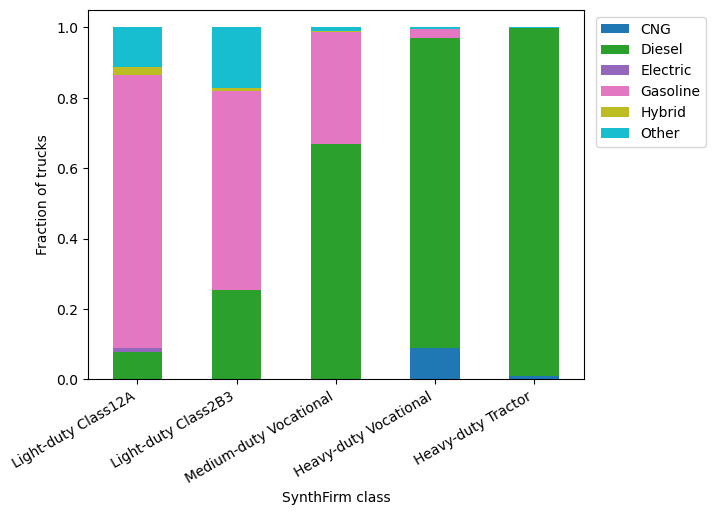

In [22]:
class_and_fuel = pd.pivot_table(experian_data_state,
                                index = 'veh_class',
                                columns = 'fuel_type_1',
                                values = 'vehicle_count',
                                aggfunc = 'sum')
class_and_fuel = class_and_fuel.loc[order_of_row]
# normalize
class_label = experian_data_state.fuel_type_1.unique()
class_and_fuel.loc[:, class_label] = \
    class_and_fuel.loc[:, class_label].div(class_and_fuel.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_fuel.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'tab10')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('SynthFirm class')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(path_to_experian, 'plot', 
                         selected_state + '_count_by_fuel_synthfirm_class.png'), bbox_inches = 'tight')
plt.show()

In [7]:
experian_data.loc[:, 'naics_lvl3'].fillna(np.nan, inplace = True)
count_by_naics = \
experian_data.groupby('naics_lvl3')[['vehicle_count']].sum()
count_by_naics = count_by_naics.sort_values(by = 'vehicle_count', ascending = False)
count_by_naics.head(20)

,vehicle_count
naics_lvl3,
238,131262.0
484,88884.0
541,78754.0
,66765.0
236,54640.0
561,54438.0
532,51870.0
423,51149.0
921,35813.0


In [9]:
print(count_by_naics['vehicle_count'].sum())
print(experian_data.vehicle_count.sum())

1122594.0
7945576.0


In [15]:
experian_data.loc[experian_data['naics_lvl3'].isna(), 'vehicle_count'].sum()

6822982.0

In [12]:
experian_data['naics_lvl3'].unique()

array(['   ', '221', '236', '237', '238', '326', '332', '423', '424',
       '484', '519', '524', '532', '541', '561', '562', '811', '925', nan,
       '112', '445', '551', '721', '722', '921', '443', '451', '485',
       '113', '212', '333', '486', '492', '517', '523', '621', '713',
       '336', '441', '444', '533', '611', '111', '115', '312', '321',
       '327', '335', '922', '331', '453', '493', '511', '531', '813',
       '442', '624', '522', '814', '339', '488', '812', '311', '425',
       '322', '324', '337', '454', '211', '314', '712', '325', '711',
       '213', '323', '446', '623', '313', '315', '447', '482', '515',
       '518', '483', '512', '481', '334', '480', '448', '452', '622',
       '926', '924', '928', '491', '810', '316', '620', '923', '110',
       '114', '487', '525', '510', '927', '710', '920', '420', '440',
       '521', '520'], dtype=object)